# PISA Experiment Results Explorer

This notebook allows you to explore the results from PISA (Provably Inferior Scheduling Algorithm) experiments interactively.

**Select a scheduler pair** to visualize:
- Task graphs (initial vs optimized)
- Network topology
- Actual schedules from both schedulers
- Simulated annealing energy progression
- Hyperparameters and statistics

## 1. Import Required Libraries

In [10]:
import pathlib
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from IPython.display import display, HTML
import sys
from itertools import accumulate

# Add the saga package to the path
sys.path.insert(0, str(pathlib.Path.cwd().parent.parent.parent / "src"))

from saga.pisa import SCHEDULERS
from saga.schedulers.data.random import Network, TaskGraph
from saga.utils.draw import draw_task_graph, draw_network, draw_gantt
from saga.pisa.simulated_annealing import SimulatedAnnealingConfig, SimulatedAnnealingIteration, SimulatedAnnealingRun

# Set up plotting style
plt.style.use('default')
%matplotlib inline

# Results directory
results_dir = pathlib.Path("results")

## 2. Load All Experiment Results

In [11]:
from typing import Dict


def get_available_experiments(results_dir: pathlib.Path) -> Dict[pathlib.Path, SimulatedAnnealingRun]:
    """Get list of all available experiment pairs."""
    experiments: Dict[pathlib.Path, SimulatedAnnealingRun] = {}
    
    for run_dir in sorted(results_dir.glob("*_vs_*")):
        if not run_dir.is_dir():
            continue
        
        run_json = run_dir / "run.json"
        if not run_json.exists():
            continue
        
        parts = run_dir.name.split("_vs_")
        if len(parts) == 2:
            experiments[run_dir] = SimulatedAnnealingRun.model_validate_json(run_json.read_text())
    
    return experiments

# Load available experiments
experiments = get_available_experiments(results_dir)
experiments

{PosixPath('results/BIL_vs_CPoP'): SimulatedAnnealingRun(name='BIL_vs_CPoP_try2', scheduler='CPoP', base_scheduler='BIL', config=SimulatedAnnealingConfig(max_iterations=1000, max_temp=10.0, min_temp=0.1, cooling_rate=0.99, change_types=['TaskGraphAddDependency', 'TaskGraphDeleteDependency', 'TaskGraphChangeDependencyWeight', 'TaskGraphChangeTaskWeight', 'NetworkChangeEdgeWeight']), initial_network=Network(nodes=frozenset({NetworkNode(name='1', speed=0.14931249553607975), NetworkNode(name='2', speed=0.31600861459506463), NetworkNode(name='0', speed=0.39777595076156674)}), edges=frozenset({NetworkEdge(source='0', target='2', speed=1.0012984679687076), NetworkEdge(source='0', target='1', speed=1.0000918221580737), NetworkEdge(source='1', target='2', speed=1.0027826817159016), NetworkEdge(source='2', target='2', speed=1000308753.5022068), NetworkEdge(source='0', target='0', speed=1009059984.4944155), NetworkEdge(source='1', target='1', speed=1002183996.1653023)})), initial_task_graph=TaskG

## 3. Select a Scheduler Pair to Explore

Choose an experiment by index from the table above.

In [12]:
base_scheduler, scheduler = 'CPoP', 'HEFT'

exp_path, experiment = next(
    (path, data) for path, data in experiments.items()
    if data.base_scheduler == base_scheduler and data.scheduler == scheduler
)

print(f"✓ Loaded Experiment:")
print(f"  Base Scheduler: {experiment.base_scheduler}")
print(f"  Scheduler: {experiment.scheduler}")
print(f"  Best Makespan Ratio: {experiment.best_energy:.4f}")
print(f"  Iterations Completed: {experiment.num_iterations}")
print(f"  Status: {'✓ Completed' if experiment.completed else '✗ Incomplete'}")

✓ Loaded Experiment:
  Base Scheduler: CPoP
  Scheduler: HEFT
  Best Makespan Ratio: 1.4971
  Iterations Completed: 460
  Status: ✓ Completed


## 4. Hyperparameters and Configuration

In [13]:
# experiment.config
for name, value in experiment.config.model_dump().items():
    print(f"  {name}: {value}")

  max_iterations: 1000
  max_temp: 10.0
  min_temp: 0.1
  cooling_rate: 0.99
  change_types: ['TaskGraphAddDependency', 'TaskGraphDeleteDependency', 'TaskGraphChangeDependencyWeight', 'TaskGraphChangeTaskWeight', 'NetworkChangeEdgeWeight', 'NetworkChangeNodeWeight']


## 5. Simulated Annealing Progress

Load and visualize the optimization history (if available).

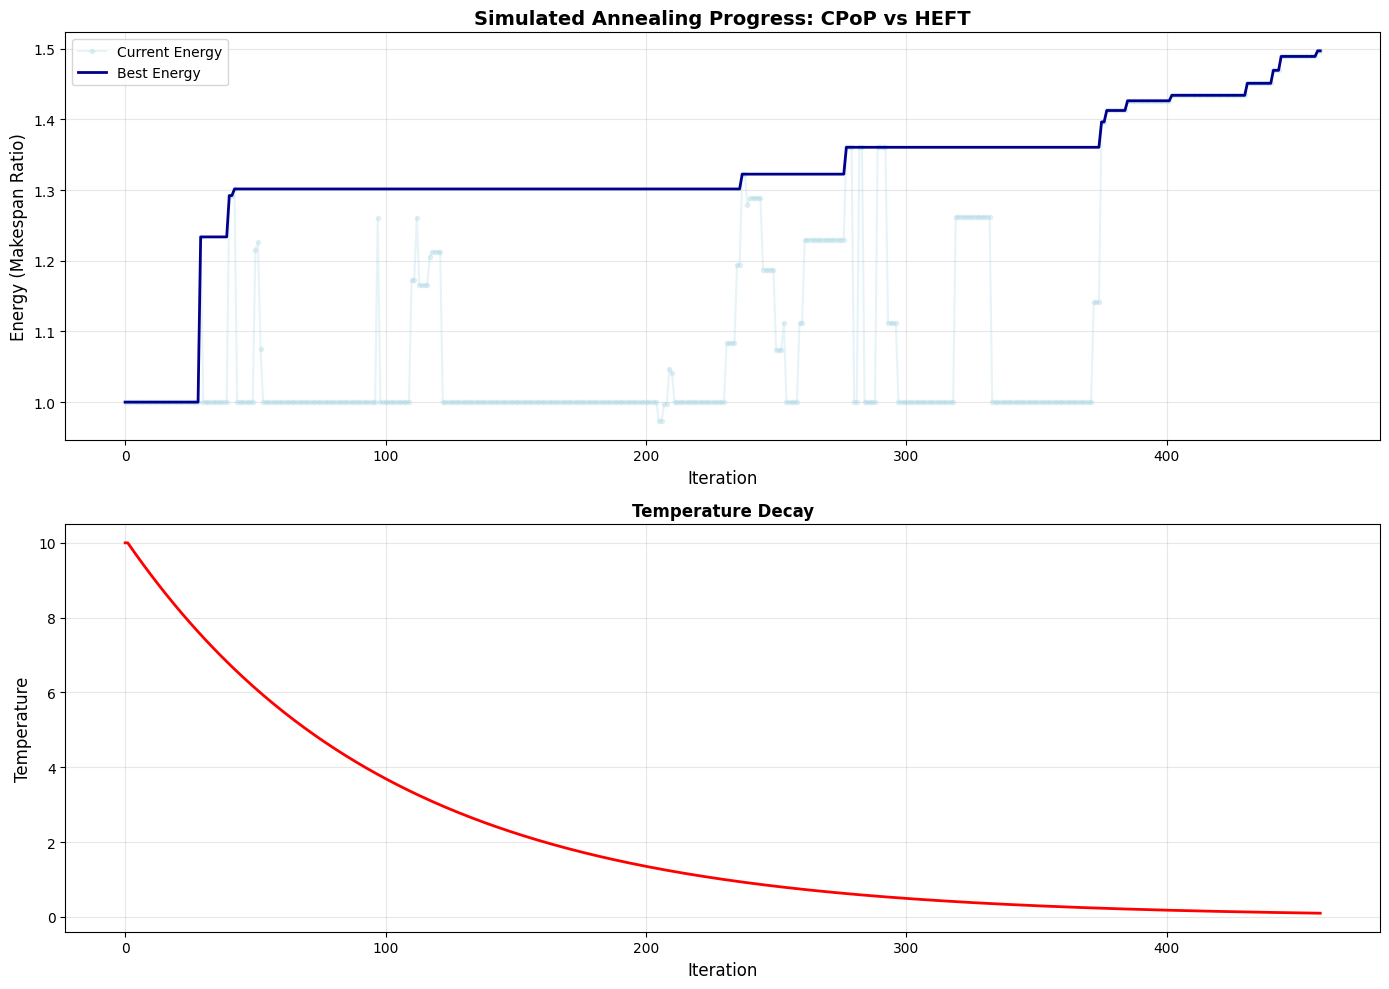


Optimization Summary:
  Starting Energy: 1.0000
  Final Energy: 1.4971
  Improvement: 0.4971 (+49.7%)
  Total Iterations: 460


In [14]:
# Check for iteration history directory
iterations_dir = exp_path / "iterations"
iteration_files = sorted(iterations_dir.glob("*.json"))

history = [
    SimulatedAnnealingIteration.model_validate_json(iter_file.read_text())
    for iter_file in iteration_files
]

# Extract energy values
iterations = [item.iteration for item in history]
# map reduce to accumulate best energies
energies = list(accumulate(
    (item.current_energy for item in history),
    func=max
))
current_energies = [item.current_energy for item in history]
temperatures = [item.temperature or 0 for item in history]

# Create plots
axes: list[Axes]
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Energy plot
axes[0].plot(iterations, current_energies, 'o-', alpha=0.3, markersize=3, label='Current Energy', color='lightblue')
axes[0].plot(iterations, energies, '-', linewidth=2, label='Best Energy', color='darkblue')
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Energy (Makespan Ratio)', fontsize=12)
axes[0].set_title(f'Simulated Annealing Progress: {experiment.base_scheduler} vs {experiment.scheduler}', 
                    fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Temperature plot
axes[1].plot(iterations, temperatures, '-', color='red', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Temperature', fontsize=12)
axes[1].set_title('Temperature Decay', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimization Summary:")
print(f"  Starting Energy: {energies[0]:.4f}")
print(f"  Final Energy: {energies[-1]:.4f}")
print(f"  Improvement: {energies[-1] - energies[0]:.4f} ({((energies[-1]/energies[0])-1)*100:+.1f}%)")
print(f"  Total Iterations: {len(iterations)}")

In [15]:
best_iteration = max(history, key=lambda x: x.current_energy)

/tmp/ipykernel_569260/2545507039.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


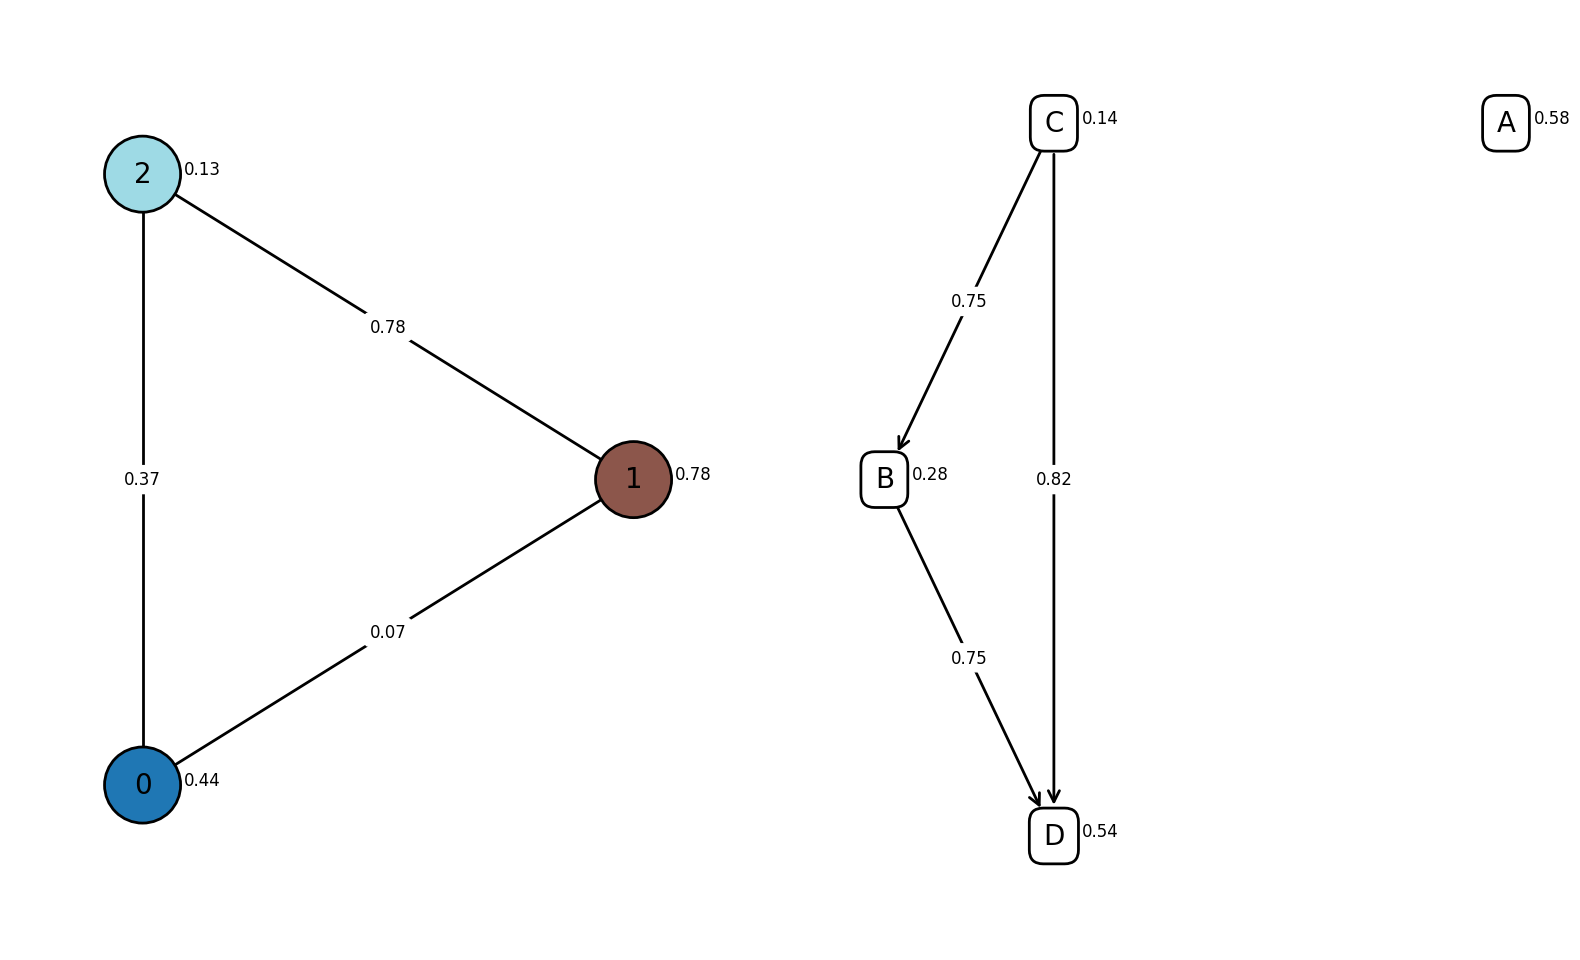

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

draw_network(best_iteration.current_network.graph, axis=ax1)
draw_task_graph(best_iteration.current_task_graph.graph, axis=ax2)
fig.show()

/tmp/ipykernel_569260/2455379817.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


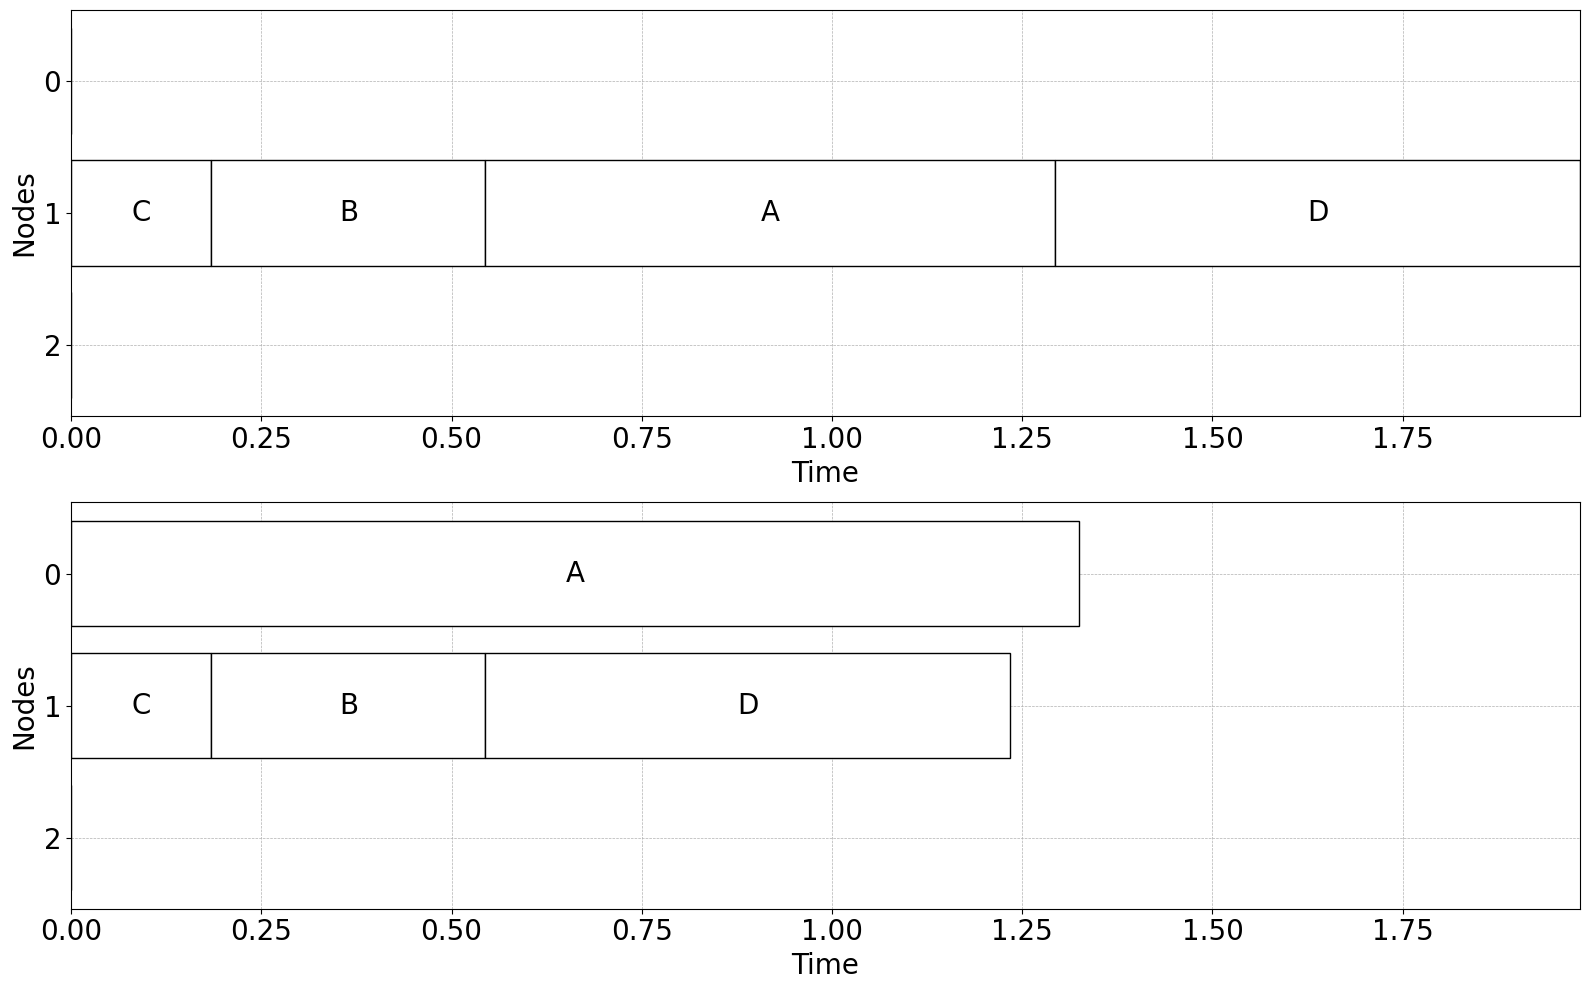

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

max_makespan = max(best_iteration.current_schedule.makespan, best_iteration.current_base_schedule.makespan)
draw_gantt(
    schedule=best_iteration.current_schedule.mapping,
    axis=ax1,
    xmax=max_makespan
)
draw_gantt(
    schedule=best_iteration.current_base_schedule.mapping,
    axis=ax2,
    xmax=max_makespan
)

fig.show()